In [2]:
# Import libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Data Processing

In [19]:
# Read in the trip summary data
trips_file_path = '../data/trip_summary_201808_201903.csv'
weather_file_path = '../data/hourly_weather_201901_201903.csv'
cluster_file_path = '../exploratory/clustering/clusters_spectral_clustering.csv'

trips_raw = pd.read_csv(trips_file_path).dropna()
weather = pd.read_csv(weather_file_path).dropna()
clusters = pd.read_csv(cluster_file_path).dropna()

# Filter on start_date >= '2019-01-01'
trips = trips_raw[trips_raw['start_date'] >= '2018-08-01']
trips['start_date'].astype('object') # convert back to object type

# Group trips by start_period
trips = trips.groupby(['start_date'
                       , 'start_period'
                       , 'start_station_id'
                       , 'start_station_name'
                       , 'start_station_cap'
                       , 'start_station_has_kiosk'
                       , 'end_station_id'
                       , 'end_station_name'
                       , 'end_station_cap'
                       , 'end_station_has_kiosk'
                       , 'start_station_latitude'
                       , 'start_station_longitude'
                       , 'end_station_latitude'
                       , 'end_station_longitude']).sum().reset_index()
trips = trips.drop(['start_hour'], axis=1) # drop start_hour
trips = trips[trips['trip_count'] <= 60] # outlier removal

print(len(trips))
print(trips['start_station_id'].nunique())
trips.head()

812479
161


,start_date,start_period,start_station_id,start_station_name,start_station_cap,start_station_has_kiosk,end_station_id,end_station_name,end_station_cap,end_station_has_kiosk,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,sum_duration_sec,sum_duration_min,trip_count,subscriber_trip_count,customer_trip_count
0,2018-08-01,afternoon,3,Powell St BART Station (Market St at 4th St),35,True,5,Powell St BART Station (Market St at 5th St),35,True,37.786375,-122.404904,37.783899,-122.408445,498,8.300000,2,0,2
1,2018-08-01,afternoon,3,Powell St BART Station (Market St at 4th St),35,True,6,The Embarcadero at Sansome St,23,True,37.786375,-122.404904,37.804770,-122.403234,1028,17.133333,2,2,0
2,2018-08-01,afternoon,3,Powell St BART Station (Market St at 4th St),35,True,11,Davis St at Jackson St,35,True,37.786375,-122.404904,37.797280,-122.398436,1042,17.366667,2,2,0
3,2018-08-01,afternoon,3,Powell St BART Station (Market St at 4th St),35,True,15,San Francisco Ferry Building (Harry Bridges Pl...,38,True,37.786375,-122.404904,37.795392,-122.394203,3844,64.066667,4,2,2
4,2018-08-01,afternoon,3,Powell St BART Station (Market St at 4th St),35,True,16,Steuart St at Market St,23,True,37.786375,-122.404904,37.794130,-122.394430,4950,82.500000,10,4,6


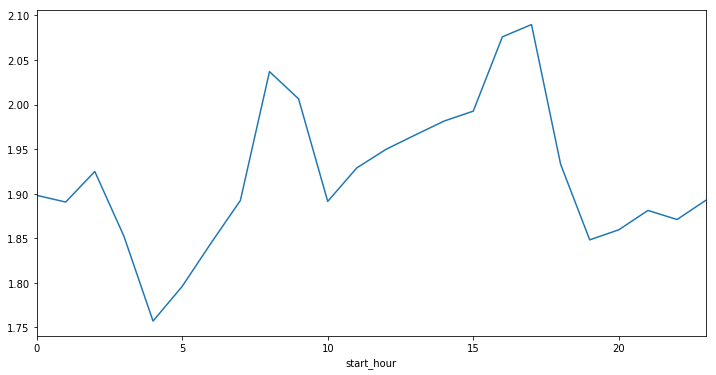

In [20]:
# Quick check: Plot trip counts by start_hour to check if timezone is correct

# To print pyplot output inline in the notebook withput calling plt.show()
%matplotlib inline

# Increase standard plot size
plt.rcParams['figure.figsize'] = (12, 6)

# Calculate and plot average trip_count grouped by start_hour
trips_by_hour = trips_raw.groupby('start_hour')['trip_count'].mean()
trips_by_hour.plot()

# Comment: we can see that the peaks in activity happen in the morning and late afternoon.
# This indicates that the timezone of the datetimes are in PST.

In [21]:
# Data quality checks
print(trips.dtypes)
print(weather.dtypes)
print(clusters.dtypes)

print('Number of NaNs in the trips df:\n', trips.isnull().sum(), '\n')
print('Number of NaNs in the weather df:\n', weather.isnull().sum(), '\n')
print('Number of NaNs in the weather df:\n', clusters.isnull().sum(), '\n')

print(trips.describe())

start_date                  object
start_period                object
start_station_id             int64
start_station_name          object
start_station_cap            int64
start_station_has_kiosk       bool
end_station_id               int64
end_station_name            object
end_station_cap              int64
end_station_has_kiosk         bool
start_station_latitude     float64
start_station_longitude    float64
end_station_latitude       float64
end_station_longitude      float64
sum_duration_sec             int64
sum_duration_min           float64
trip_count                   int64
subscriber_trip_count        int64
customer_trip_count          int64
dtype: object
start_date       object
start_hour        int64
datetime_hour    object
datetime_mod     object
temperature      object
wind             object
precip_          object
dtype: object
station_id             int64
station_name          object
station_latitude     float64
station_longitude    float64
cluster                

In [22]:
# Feature engineering

# Merge trips and other datasets: weather, cluster
# trips = pd.merge(trips, weather, on=['start_date', 'start_hour'], how='inner')
clusters = clusters[['station_id', 'cluster']]
trips = pd.merge(trips, clusters, left_on=['start_station_id'], right_on=['station_id'], how='inner')
trips = pd.merge(trips, clusters, left_on=['end_station_id'], right_on=['station_id'], how='inner')
trips = trips.drop(['station_id_x', 'station_id_y'], axis=1)
trips = trips.rename(index=str, columns={'cluster_x': 'start_station_cluster', 'cluster_y': 'end_station_cluster'})

trips['start_station_has_kiosk'] = trips['start_station_has_kiosk'].astype('bool')
trips['end_station_has_kiosk'] = trips['end_station_has_kiosk'].astype('bool')
trips['start_dow'] = trips['start_date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')).dt.weekday_name
# trips['temperature'] = trips['temperature'].str.split(" ", expand = True)[0].astype('float')
# trips['wind'] = trips['wind'].str.split(" ", expand = True)[0].astype('float')
# trips['precip_'] = trips['precip_'].str.split(" ", expand = True)[0].astype('float')
trips['start_date'] = pd.to_datetime(trips['start_date'], format='%Y-%m-%d', utc=True)

print(len(trips))
print(trips.dtypes)
trips.head()

884503
start_date                 datetime64[ns, UTC]
start_period                            object
start_station_id                         int64
start_station_name                      object
start_station_cap                        int64
start_station_has_kiosk                   bool
end_station_id                           int64
end_station_name                        object
end_station_cap                          int64
end_station_has_kiosk                     bool
start_station_latitude                 float64
start_station_longitude                float64
end_station_latitude                   float64
end_station_longitude                  float64
sum_duration_sec                         int64
sum_duration_min                       float64
trip_count                               int64
subscriber_trip_count                    int64
customer_trip_count                      int64
start_station_cluster                    int64
end_station_cluster                      int64
start_

,start_date,start_period,start_station_id,start_station_name,start_station_cap,start_station_has_kiosk,end_station_id,end_station_name,end_station_cap,end_station_has_kiosk,...,end_station_latitude,end_station_longitude,sum_duration_sec,sum_duration_min,trip_count,subscriber_trip_count,customer_trip_count,start_station_cluster,end_station_cluster,start_dow
0,2018-08-01 00:00:00+00:00,afternoon,3,Powell St BART Station (Market St at 4th St),35,True,5,Powell St BART Station (Market St at 5th St),35,True,...,37.783899,-122.408445,498,8.300000,2,0,2,3,3,Wednesday
1,2018-08-01 00:00:00+00:00,morning,3,Powell St BART Station (Market St at 4th St),35,True,5,Powell St BART Station (Market St at 5th St),35,True,...,37.783899,-122.408445,258,4.300000,2,2,0,3,3,Wednesday
2,2018-08-02 00:00:00+00:00,afternoon,3,Powell St BART Station (Market St at 4th St),35,True,5,Powell St BART Station (Market St at 5th St),35,True,...,37.783899,-122.408445,372,6.200000,2,2,0,3,3,Thursday
3,2018-08-03 00:00:00+00:00,afternoon,3,Powell St BART Station (Market St at 4th St),35,True,5,Powell St BART Station (Market St at 5th St),35,True,...,37.783899,-122.408445,322,5.366667,2,2,0,3,3,Friday
4,2018-08-04 00:00:00+00:00,afternoon,3,Powell St BART Station (Market St at 4th St),35,True,5,Powell St BART Station (Market St at 5th St),35,True,...,37.783899,-122.408445,488,8.133333,2,2,0,3,3,Saturday


In [30]:
# New training dataset: aggregating the trip counts per station as a net flow

# Aggregate per start station to count total trips originating from station
trips_out = trips.groupby(['start_date', 'start_dow', 'start_period' \
                           , 'start_station_id', 'start_station_cluster', 'start_station_cap', 'start_station_has_kiosk']) \
                           ['trip_count'].sum().reset_index()
trips_out = trips_out.rename(index=str, columns={'start_station_id': 'station_id', 'start_station_cluster': 'station_cluster'
                                                , 'start_station_cap': 'station_cap', 'start_station_has_kiosk': 'station_has_kiosk'})

# Aggregate per end station to count total trips ending in station
trips_in = trips.groupby(['start_date', 'start_dow', 'start_period' \
                          , 'end_station_id', 'end_station_cluster', 'end_station_cap', 'end_station_has_kiosk']) \
                           ['trip_count'].sum().reset_index()
trips_in = trips_in.rename(index=str, columns={'end_station_id': 'station_id', 'end_station_cluster': 'station_cluster'
                                              , 'end_station_cap': 'station_cap', 'end_station_has_kiosk': 'station_has_kiosk'})

# Combine the two aggregates to create a net total trips per station
trips_net = pd.merge(trips_out, trips_in, on=['start_date', 'start_dow', 'start_period' \
                                              , 'station_id', 'station_cluster' \
                                              , 'station_cap', 'station_has_kiosk'], how='outer')
trips_net = trips_net.rename(index=str, columns={'trip_count_x': 'trip_count_out', 'trip_count_y': 'trip_count_in'})
trips_net.fillna(0, inplace=True) # replace NaNs with 0 in trip_count
trips_net['trip_count_net'] = trips_net['trip_count_in'] - trips_net['trip_count_out'] # compute net trip count

trips_net

,start_date,start_dow,start_period,station_id,station_cluster,station_cap,station_has_kiosk,trip_count_out,trip_count_in,trip_count_net
0,2018-08-01 00:00:00+00:00,Wednesday,afternoon,3,3,35,True,92.0,78.0,-14.0
1,2018-08-01 00:00:00+00:00,Wednesday,afternoon,4,1,35,True,2.0,6.0,4.0
2,2018-08-01 00:00:00+00:00,Wednesday,afternoon,5,3,35,True,70.0,92.0,22.0
3,2018-08-01 00:00:00+00:00,Wednesday,afternoon,6,1,23,True,98.0,98.0,0.0
4,2018-08-01 00:00:00+00:00,Wednesday,afternoon,8,1,23,True,46.0,20.0,-26.0
5,2018-08-01 00:00:00+00:00,Wednesday,afternoon,9,1,19,True,56.0,24.0,-32.0
6,2018-08-01 00:00:00+00:00,Wednesday,afternoon,10,1,31,True,26.0,16.0,-10.0
7,2018-08-01 00:00:00+00:00,Wednesday,afternoon,11,1,35,True,36.0,22.0,-14.0
8,2018-08-01 00:00:00+00:00,Wednesday,afternoon,13,2,23,True,66.0,32.0,-34.0
9,2018-08-01 00:00:00+00:00,Wednesday,afternoon,14,1,31,True,66.0,28.0,-38.0


In [8]:
# Historical lookback features for per station pair trips dataset (trips)

# Create weekly lookback features for trip count
trips_add7 = trips[['start_date', 'start_period', 'start_station_id', 'end_station_id', 'trip_count']]
trips_add14 = trips[['start_date', 'start_period', 'start_station_id', 'end_station_id', 'trip_count']]
trips_add21 = trips[['start_date', 'start_period', 'start_station_id', 'end_station_id', 'trip_count']]
trips_add28 = trips[['start_date', 'start_period', 'start_station_id', 'end_station_id', 'trip_count']]

# Offset the start_date by 7 / 14 / 21 / 28
trips_add7['start_date'] = trips_add7["start_date"] + pd.DateOffset(days=7)
trips_add14['start_date'] = trips_add14["start_date"] + pd.DateOffset(days=14)
trips_add21['start_date'] = trips_add21["start_date"] + pd.DateOffset(days=21)
trips_add28['start_date'] = trips_add28["start_date"] + pd.DateOffset(days=28)

trips_add7.rename(columns={"trip_count": "trip_count_prev7"}, inplace=True)
trips_add14.rename(columns={"trip_count": "trip_count_prev14"}, inplace=True)
trips_add21.rename(columns={"trip_count": "trip_count_prev21"}, inplace=True)
trips_add28.rename(columns={"trip_count": "trip_count_prev28"}, inplace=True)

# Create average trip count features per start_period over the past week
trips_per = trips[['start_station_id', 'end_station_id', 'start_period', 'start_date', 'trip_count']] \
    .sort_values(by=['start_station_id', 'end_station_id', 'start_period', 'start_date'])

trips_merge_per = pd.merge(trips_per, trips_per, on=['start_station_id', 'end_station_id', 'start_period'], how='left')
trips_merge_per = trips_merge_per[trips_merge_per['start_date_y'].between(trips_merge_per['start_date_x'] - pd.DateOffset(days=7), trips_merge_per['start_date_x'], inclusive=False)]

trips_merge_per_7d_mean = trips_merge_per.groupby(['start_station_id', 'end_station_id', 'start_period', 'start_date_x']).mean().reset_index()
trips_merge_per_7d_mean = trips_merge_per_7d_mean[['start_station_id', 'end_station_id', 'start_period', 'start_date_x', 'trip_count_y']]
trips_merge_per_7d_mean = trips_merge_per_7d_mean.rename(index=str, columns={'start_date_x': 'start_date', 'trip_count_y': 'trip_count_7d_mean'})

# Create simple average trip count features over the past 7 / 14 / 21 / 28 days
trips_merge_stn = pd.merge(trips_per, trips_per, on=['start_station_id', 'end_station_id'], how='left')
trips_merge_stn = trips_merge_stn[trips_merge_stn['start_date_y'].between(trips_merge_stn['start_date_x'] - pd.DateOffset(days=7), trips_merge_stn['start_date_x'], inclusive=False)]

trips_merge_stn_7d_mean = trips_merge_stn.groupby(['start_station_id', 'end_station_id', 'start_period_x', 'start_date_x']).mean().reset_index()
trips_merge_stn_7d_mean = trips_merge_stn_7d_mean[['start_station_id', 'end_station_id', 'start_period_x', 'start_date_x', 'trip_count_y']]
trips_merge_stn_7d_mean = trips_merge_stn_7d_mean.rename(index=str, columns={'start_period_x': 'start_period', 'start_date_x': 'start_date', 'trip_count_y': 'trip_count_7d_mean_all'})

# Create a new trips_feat df by left joining all the new features back to the original trips df
trips_feat = trips.copy()

trips_feat = pd.merge(trips_feat, trips_add7, on=['start_date', 'start_period', 'start_station_id', 'end_station_id'], how='left')
trips_feat = pd.merge(trips_feat, trips_add14, on=['start_date', 'start_period', 'start_station_id', 'end_station_id'], how='left')
trips_feat = pd.merge(trips_feat, trips_add21, on=['start_date', 'start_period', 'start_station_id', 'end_station_id'], how='left')
trips_feat = pd.merge(trips_feat, trips_add28, on=['start_date', 'start_period', 'start_station_id', 'end_station_id'], how='left')
trips_feat = pd.merge(trips_feat, trips_merge_per_7d_mean, on=['start_date', 'start_period', 'start_station_id', 'end_station_id'], how='left')
trips_feat = pd.merge(trips_feat, trips_merge_stn_7d_mean, on=['start_date', 'start_period', 'start_station_id', 'end_station_id'], how='left')

# Fill NaNs and calculate average of last 4 weeks
trips_feat.fillna(value={'trip_count_prev7':0, 'trip_count_prev14':0, 'trip_count_prev21':0, 'trip_count_prev28':0, 'trip_count_7d_mean':0, 'trip_count_7d_mean_all':0}, inplace=True)
trips_feat['trip_count_weekly_mean'] = (trips_feat['trip_count_prev7'] + trips_feat['trip_count_prev14'] + trips_feat['trip_count_prev21'] + trips_feat['trip_count_prev28']) / 4

trips_feat

,start_date,start_period,start_station_id,start_station_name,start_station_cap,start_station_has_kiosk,end_station_id,end_station_name,end_station_cap,end_station_has_kiosk,...,start_station_cluster,end_station_cluster,start_dow,trip_count_prev7,trip_count_prev14,trip_count_prev21,trip_count_prev28,trip_count_7d_mean,trip_count_7d_mean_all,trip_count_weekly_mean
0,2018-08-01 00:00:00+00:00,afternoon,3,Powell St BART Station (Market St at 4th St),35,True,5,Powell St BART Station (Market St at 5th St),35,True,...,13,1,Wednesday,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00
1,2018-08-01 00:00:00+00:00,morning,3,Powell St BART Station (Market St at 4th St),35,True,5,Powell St BART Station (Market St at 5th St),35,True,...,13,1,Wednesday,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00
2,2018-08-02 00:00:00+00:00,afternoon,3,Powell St BART Station (Market St at 4th St),35,True,5,Powell St BART Station (Market St at 5th St),35,True,...,13,1,Thursday,0.0,0.0,0.0,0.0,2.000000,2.000000,0.00
3,2018-08-03 00:00:00+00:00,afternoon,3,Powell St BART Station (Market St at 4th St),35,True,5,Powell St BART Station (Market St at 5th St),35,True,...,13,1,Friday,0.0,0.0,0.0,0.0,2.000000,2.000000,0.00
4,2018-08-04 00:00:00+00:00,afternoon,3,Powell St BART Station (Market St at 4th St),35,True,5,Powell St BART Station (Market St at 5th St),35,True,...,13,1,Saturday,0.0,0.0,0.0,0.0,2.000000,2.000000,0.00
5,2018-08-08 00:00:00+00:00,afternoon,3,Powell St BART Station (Market St at 4th St),35,True,5,Powell St BART Station (Market St at 5th St),35,True,...,13,1,Wednesday,2.0,0.0,0.0,0.0,2.000000,2.000000,0.50
6,2018-08-12 00:00:00+00:00,evening,3,Powell St BART Station (Market St at 4th St),35,True,5,Powell St BART Station (Market St at 5th St),35,True,...,13,1,Sunday,0.0,0.0,0.0,0.0,0.000000,4.000000,0.00
7,2018-08-14 00:00:00+00:00,afternoon,3,Powell St BART Station (Market St at 4th St),35,True,5,Powell St BART Station (Market St at 5th St),35,True,...,13,1,Tuesday,0.0,0.0,0.0,0.0,4.000000,3.000000,0.00
8,2018-08-15 00:00:00+00:00,afternoon,3,Powell St BART Station (Market St at 4th St),35,True,5,Powell St BART Station (Market St at 5th St),35,True,...,13,1,Wednesday,4.0,2.0,0.0,0.0,4.000000,3.000000,1.50
9,2018-08-15 00:00:00+00:00,evening,3,Powell St BART Station (Market St at 4th St),35,True,5,Powell St BART Station (Market St at 5th St),35,True,...,13,1,Wednesday,0.0,0.0,0.0,0.0,2.000000,3.000000,0.00


In [31]:
# Historical lookback features for per station net trips dataset (trips_net)

# Create weekly lookback features for trip count
trips_net_add7 = trips_net[['start_date', 'start_period', 'station_id', 'trip_count_net']]
trips_net_add14 = trips_net[['start_date', 'start_period', 'station_id', 'trip_count_net']]
trips_net_add21 = trips_net[['start_date', 'start_period', 'station_id', 'trip_count_net']]
trips_net_add28 = trips_net[['start_date', 'start_period', 'station_id', 'trip_count_net']]

# Offset the start_date by 7 / 14 / 21 / 28
trips_net_add7['start_date'] = trips_net_add7["start_date"] + pd.DateOffset(days=7)
trips_net_add14['start_date'] = trips_net_add14["start_date"] + pd.DateOffset(days=14)
trips_net_add21['start_date'] = trips_net_add21["start_date"] + pd.DateOffset(days=21)
trips_net_add28['start_date'] = trips_net_add28["start_date"] + pd.DateOffset(days=28)

trips_net_add7.rename(columns={"trip_count_net": "trip_count_net_prev7"}, inplace=True)
trips_net_add14.rename(columns={"trip_count_net": "trip_count_net_prev14"}, inplace=True)
trips_net_add21.rename(columns={"trip_count_net": "trip_count_net_prev21"}, inplace=True)
trips_net_add28.rename(columns={"trip_count_net": "trip_count_net_prev28"}, inplace=True)

# Create average trip count features per start_period over the past week
trips_net_per = trips_net[['station_id', 'start_period', 'start_date', 'trip_count_net']] \
    .sort_values(by=['station_id', 'start_period', 'start_date'])

trips_net_merge_per = pd.merge(trips_net_per, trips_net_per, on=['station_id', 'start_period'], how='left')
trips_net_merge_per = trips_net_merge_per[trips_net_merge_per['start_date_y'].between(trips_net_merge_per['start_date_x'] - pd.DateOffset(days=7), trips_net_merge_per['start_date_x'], inclusive=False)]

trips_net_merge_per_7d_mean = trips_net_merge_per.groupby(['station_id', 'start_period', 'start_date_x']).mean().reset_index()
trips_net_merge_per_7d_mean = trips_net_merge_per_7d_mean[['station_id', 'start_period', 'start_date_x', 'trip_count_net_y']]
trips_net_merge_per_7d_mean = trips_net_merge_per_7d_mean.rename(index=str, columns={'start_date_x': 'start_date', 'trip_count_net_y': 'trip_count_net_7d_mean'})

# Create simple average trip count features over the past 7 / 14 / 21 / 28 days
trips_net_merge_stn = pd.merge(trips_net_per, trips_net_per, on=['station_id'], how='left')
trips_net_merge_stn = trips_net_merge_stn[trips_net_merge_stn['start_date_y'].between(trips_net_merge_stn['start_date_x'] - pd.DateOffset(days=7), trips_net_merge_stn['start_date_x'], inclusive=False)]

trips_net_merge_stn_7d_mean = trips_net_merge_stn.groupby(['station_id', 'start_period_x', 'start_date_x']).mean().reset_index()
trips_net_merge_stn_7d_mean = trips_net_merge_stn_7d_mean[['station_id', 'start_period_x', 'start_date_x', 'trip_count_net_y']]
trips_net_merge_stn_7d_mean = trips_net_merge_stn_7d_mean.rename(index=str, columns={'start_period_x': 'start_period', 'start_date_x': 'start_date', 'trip_count_net_y': 'trip_count_net_7d_mean_all'})

# Create a new trips_feat df by left joining all the new features back to the original trips df
trips_net_feat = trips_net.copy()

trips_net_feat = pd.merge(trips_net_feat, trips_net_add7, on=['start_date', 'start_period', 'station_id'], how='left')
trips_net_feat = pd.merge(trips_net_feat, trips_net_add14, on=['start_date', 'start_period', 'station_id'], how='left')
trips_net_feat = pd.merge(trips_net_feat, trips_net_add21, on=['start_date', 'start_period', 'station_id'], how='left')
trips_net_feat = pd.merge(trips_net_feat, trips_net_add28, on=['start_date', 'start_period', 'station_id'], how='left')
trips_net_feat = pd.merge(trips_net_feat, trips_net_merge_per_7d_mean, on=['start_date', 'start_period', 'station_id'], how='left')
trips_net_feat = pd.merge(trips_net_feat, trips_net_merge_stn_7d_mean, on=['start_date', 'start_period', 'station_id'], how='left')

# Fill NaNs and calculate average of last 4 weeks
trips_net_feat.fillna(value={'trip_count_net_prev7':0, 'trip_count_net_prev14':0, 'trip_count_net_prev21':0, 'trip_count_net_prev28':0, 'trip_count_net_7d_mean':0, 'trip_count_net_7d_mean_all':0}, inplace=True)
trips_net_feat['trip_count_net_weekly_mean'] = (trips_net_feat['trip_count_net_prev7'] + trips_net_feat['trip_count_net_prev14'] + trips_net_feat['trip_count_net_prev21'] + trips_net_feat['trip_count_net_prev28']) / 4

trips_net_feat

,start_date,start_dow,start_period,station_id,station_cluster,station_cap,station_has_kiosk,trip_count_out,trip_count_in,trip_count_net,trip_count_net_prev7,trip_count_net_prev14,trip_count_net_prev21,trip_count_net_prev28,trip_count_net_7d_mean,trip_count_net_7d_mean_all,trip_count_net_weekly_mean
0,2018-08-01 00:00:00+00:00,Wednesday,afternoon,3,3,35,True,92.0,78.0,-14.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00
1,2018-08-01 00:00:00+00:00,Wednesday,afternoon,4,1,35,True,2.0,6.0,4.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00
2,2018-08-01 00:00:00+00:00,Wednesday,afternoon,5,3,35,True,70.0,92.0,22.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00
3,2018-08-01 00:00:00+00:00,Wednesday,afternoon,6,1,23,True,98.0,98.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00
4,2018-08-01 00:00:00+00:00,Wednesday,afternoon,8,1,23,True,46.0,20.0,-26.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00
5,2018-08-01 00:00:00+00:00,Wednesday,afternoon,9,1,19,True,56.0,24.0,-32.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00
6,2018-08-01 00:00:00+00:00,Wednesday,afternoon,10,1,31,True,26.0,16.0,-10.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00
7,2018-08-01 00:00:00+00:00,Wednesday,afternoon,11,1,35,True,36.0,22.0,-14.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00
8,2018-08-01 00:00:00+00:00,Wednesday,afternoon,13,2,23,True,66.0,32.0,-34.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00
9,2018-08-01 00:00:00+00:00,Wednesday,afternoon,14,1,31,True,66.0,28.0,-38.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00


In [32]:
# Further filter on start_date >= 2019-09-01 to ensure that every row gets a fair lookback opp
trips_feat = trips_feat[trips_feat['start_date'] >= '2018-09-01']
trips_feat['start_date'].astype('object') # convert back to object type

print(len(trips_feat))
trips_feat[['start_date', 'start_period', 'start_station_name', 'end_station_name', 'trip_count_prev7', 'trip_count_prev14', 'trip_count_prev21', 'trip_count_prev28', 'trip_count_7d_mean', 'trip_count_7d_mean_all', 'trip_count_weekly_mean', 'trip_count']].head(1000)

# Repeat for trip_net_feat
trips_net_feat = trips_net_feat[trips_net_feat['start_date'] >= '2018-09-01']
trips_net_feat['start_date'].astype('object') # convert back to object type

print(len(trips_net_feat))
trips_net_feat[['start_date', 'start_period', 'station_id', 'trip_count_net_prev7', 'trip_count_net_prev14', 'trip_count_net_prev21', 'trip_count_net_prev28', 'trip_count_net_7d_mean', 'trip_count_net_7d_mean_all', 'trip_count_net_weekly_mean', 'trip_count_net']].head(1000)

1675311
105877


,start_date,start_period,station_id,trip_count_net_prev7,trip_count_net_prev14,trip_count_net_prev21,trip_count_net_prev28,trip_count_net_7d_mean,trip_count_net_7d_mean_all,trip_count_net_weekly_mean,trip_count_net
13086,2018-09-01 00:00:00+00:00,afternoon,3,34.0,10.0,-4.0,16.0,-5.333333,-0.416667,14.0,-12.0
13087,2018-09-01 00:00:00+00:00,afternoon,4,0.0,4.0,0.0,-2.0,3.000000,-0.315789,0.5,-14.0
13088,2018-09-01 00:00:00+00:00,afternoon,5,12.0,-4.0,-6.0,24.0,22.333333,-0.727273,6.5,-20.0
13089,2018-09-01 00:00:00+00:00,afternoon,6,2.0,34.0,54.0,40.0,-15.666667,8.476190,32.5,12.0
13090,2018-09-01 00:00:00+00:00,afternoon,8,32.0,26.0,18.0,30.0,-13.666667,2.105263,26.5,26.0
13091,2018-09-01 00:00:00+00:00,afternoon,9,24.0,22.0,12.0,8.0,-22.000000,-2.555556,16.5,18.0
13092,2018-09-01 00:00:00+00:00,afternoon,10,14.0,-12.0,-12.0,0.0,2.333333,1.304348,-2.5,10.0
13093,2018-09-01 00:00:00+00:00,afternoon,11,0.0,-8.0,10.0,-14.0,-15.000000,-1.181818,-3.0,20.0
13094,2018-09-01 00:00:00+00:00,afternoon,13,8.0,4.0,4.0,0.0,-14.666667,0.285714,4.0,0.0
13095,2018-09-01 00:00:00+00:00,afternoon,14,8.0,10.0,-8.0,10.0,-25.333333,1.238095,5.0,2.0


In [34]:
# Split data into training and test set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Exclude last week of March <- saved for prediction task later
# trips_model = trips_feat[trips_feat['start_date'] < '2019-03-01']
trips_model = trips_net_feat[trips_net_feat['start_date'] < '2019-03-01']

X = trips_model[[
    # selected model features for trips_feat
#     'start_dow'
#     , 'start_period'
#     , 'start_station_cap'
#     , 'start_station_has_kiosk'
#     , 'end_station_cap'
#     , 'end_station_has_kiosk'
#     , 'start_station_cluster'
#     , 'end_station_cluster'
#     , 'trip_count_prev7'
#     , 'trip_count_prev14'
#     , 'trip_count_prev21'
#     , 'trip_count_prev28'
#     , 'trip_count_7d_mean'
#     , 'trip_count_7d_mean_all'
#     , 'trip_count_weekly_mean'
#     , 'temperature'
#     , 'wind'
#     , 'precip_'
    
    # selected model features for trips_net_feat
    'start_dow'
    , 'start_period'
    , 'station_cap'
    , 'station_has_kiosk'
    , 'station_cluster'
    , 'trip_count_net_prev7'
    , 'trip_count_net_prev14'
    , 'trip_count_net_prev21'
    , 'trip_count_net_prev28'
    , 'trip_count_net_7d_mean'
    , 'trip_count_net_7d_mean_all'
    , 'trip_count_net_weekly_mean'
#     , 'temperature'
#     , 'wind'
#     , 'precip_'
]]

# y = trips_model['trip_count']
y = trips_model['trip_count_net']

# onehot_cols = ['start_period', 'start_station_cluster', 'end_station_cluster', 'start_dow']
onehot_cols = ['start_period', 'station_cluster', 'start_dow']

for k, v in enumerate(onehot_cols):
    one_hot = pd.get_dummies(X[v], prefix=v)
    X = X.drop(v, axis=1) # drop column as it is now encoded
    X = pd.concat([X, one_hot], axis=1) # concat the encoded dataframe to original

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
# X_test = X_test[X_test.columns.difference(['start_date'])]

print('Number of samples in training data:', len(X_train))
print('Number of samples in test data:', len(X_test))

(88683, 29)
(88683,)
Number of samples in training data: 70946
Number of samples in test data: 17737


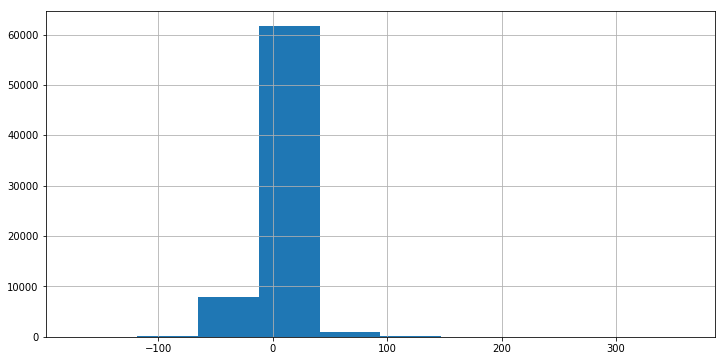

In [35]:
# Plot the distribution of the response var to check imbalance
y_train.hist()

# Comment: there is a huge imbalance towards trip_count = 1 compared to other values.
# The model may not learn the features of other responses properly.

In [37]:
# Handle imbalanced data
from sklearn.utils import resample

trips_bal = pd.concat([X_train, y_train], axis=1)
trips_bal

# # Separate majority and minority classes
# trips_maj = trips_imb[trips_imb['trip_count'] == 1]

# # Downsample majority class
# trips_maj_down = resample(trips_maj, n_samples=int(len(trips_maj)/2), random_state=100)

# for iter in sorted(trips_imb[trips_imb['trip_count'] != 1]['trip_count'].unique()):
#     trips_min = trips_imb[trips_imb['trip_count'] == iter]
    
#     # Upsample minority class
#     trips_min_up = resample(trips_min, replace=True, n_samples=int(len(trips_min)*2), random_state=100)

#     # Combine majority class with upsampled minority class
#     trips_maj_down = pd.concat([trips_maj_down, trips_min_up])

# trips_bal = trips_maj_down

# Display new class counts
# print(trips_bal['trip_count'].value_counts())
print(trips_bal['trip_count_net'].value_counts())

# Re-define training datasets
# X_train = trips_bal[trips_bal.columns.difference(['trip_count'])]
# y_train = trips_bal['trip_count']
X_train = trips_bal[trips_bal.columns.difference(['trip_count_net'])]
y_train = trips_bal['trip_count_net']

print(X_train.shape)
print(y_train.shape)

 2.0      8380
-2.0      8175
 0.0      7425
 4.0      5060
-4.0      4946
 6.0      3236
-6.0      3099
 8.0      2320
-8.0      2278
-10.0     1745
 10.0     1654
-12.0     1508
 1.0      1397
 12.0     1395
-1.0      1266
-14.0     1123
-16.0     1040
 14.0      871
-18.0      853
 16.0      748
-20.0      746
-22.0      618
 3.0       585
 18.0      552
-24.0      534
-3.0       522
 20.0      485
-26.0      420
-28.0      417
 24.0      361
          ... 
 51.0        1
 150.0       1
 228.0       1
 158.0       1
 57.0        1
 194.0       1
 69.0        1
 63.0        1
-78.0        1
 85.0        1
 232.0       1
 208.0       1
 87.0        1
-98.0        1
 206.0       1
 43.0        1
 45.0        1
 220.0       1
 234.0       1
 270.0       1
-39.0        1
-74.0        1
-120.0       1
 204.0       1
 246.0       1
 67.0        1
 360.0       1
 160.0       1
 89.0        1
 140.0       1
Name: trip_count_net, Length: 242, dtype: int64
(70946, 29)
(70946,)


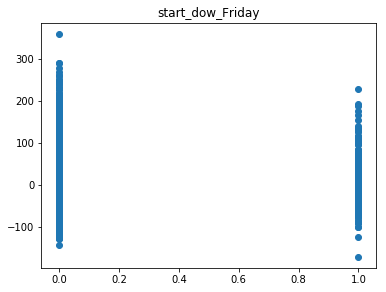

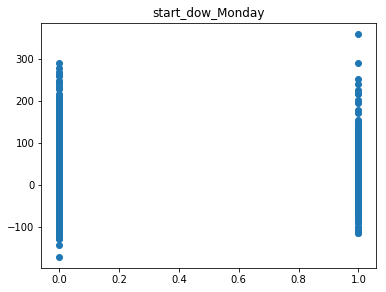

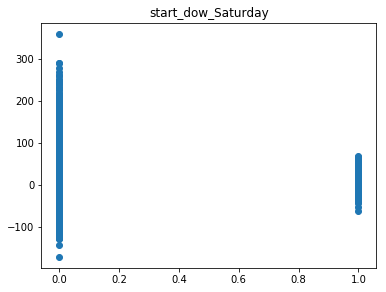

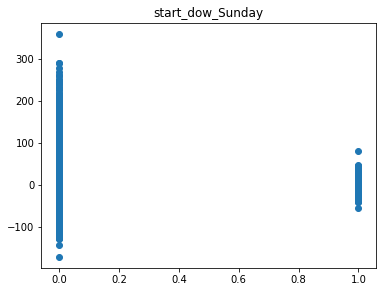

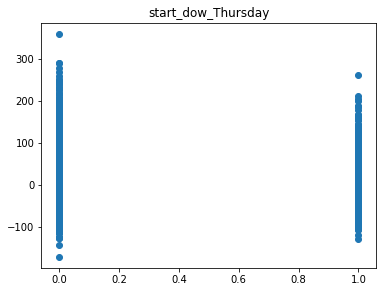

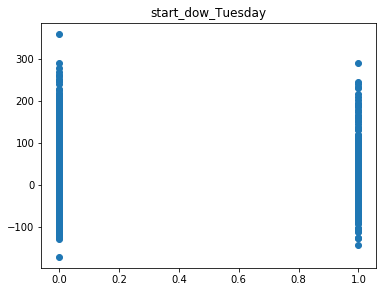

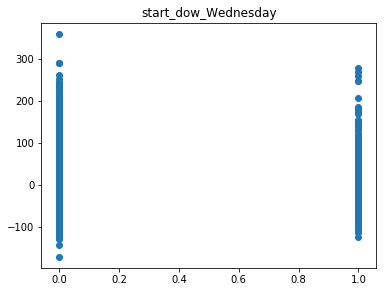

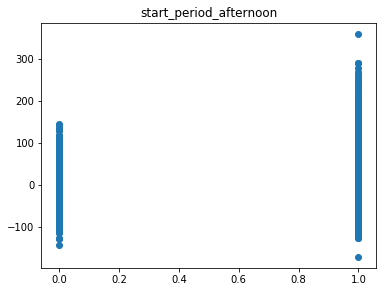

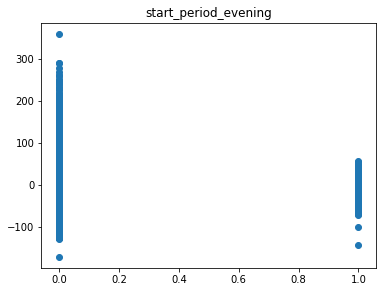

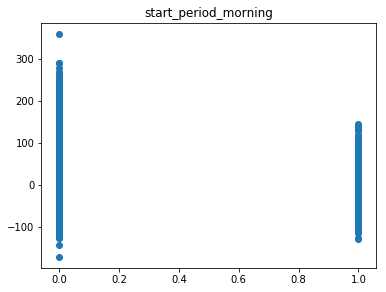

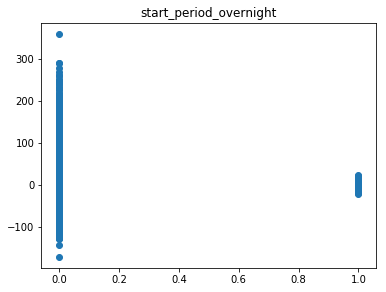

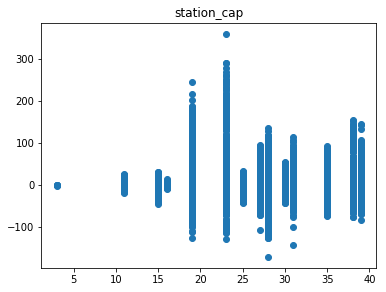

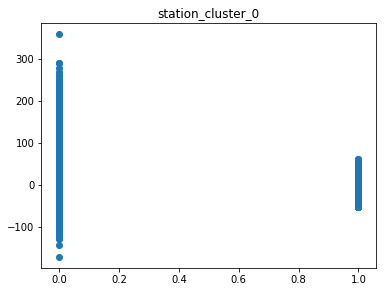

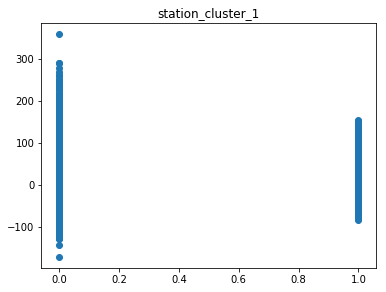

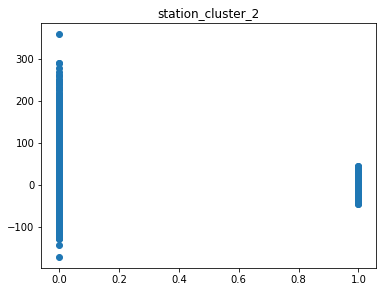

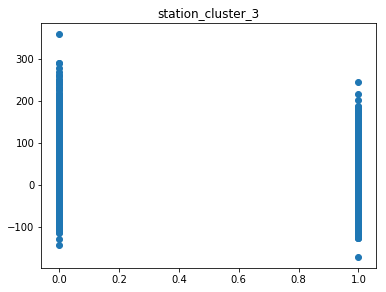

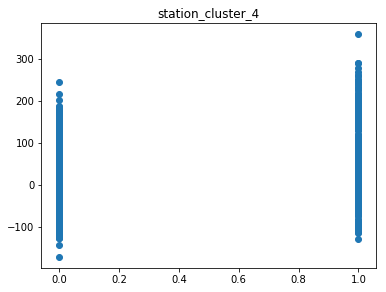

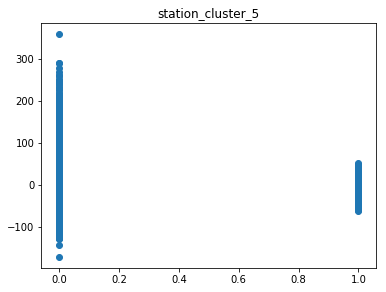

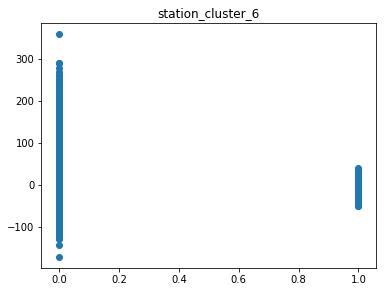

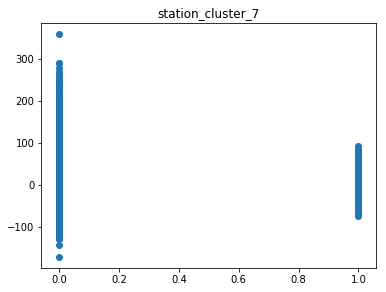

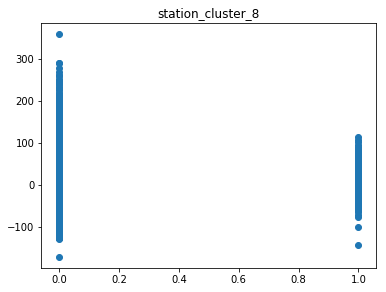

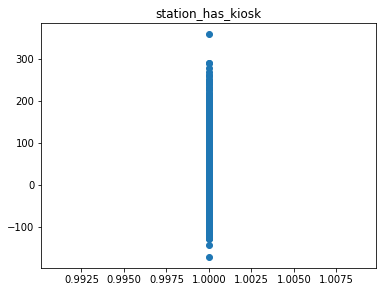

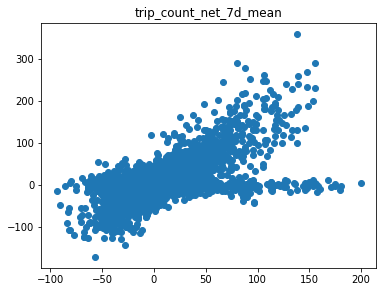

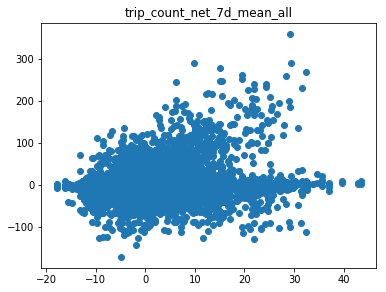

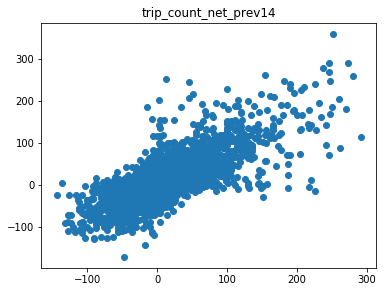

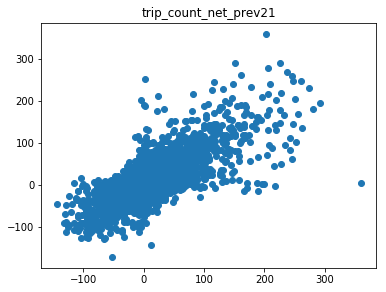

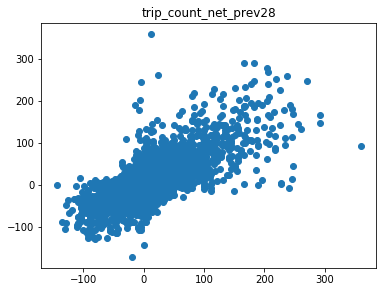

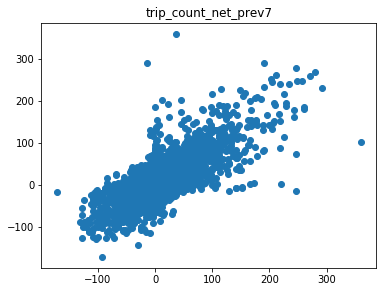

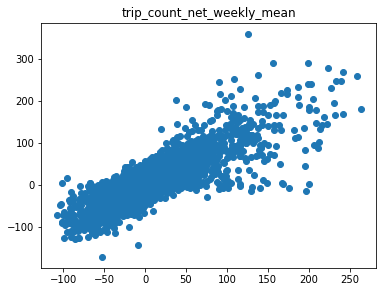

<Figure size 432x324 with 0 Axes>

In [38]:
# Plot response vs. input features
plt.rcParams['figure.figsize'] = (6, 4.5)

for col in X_train.columns:
    plt.scatter(X_train[col], y_train)
    plt.title(col)
    plt.figure()

In [40]:
# Normalize the features and generate polynomial features
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures

# X_scaler = preprocessing.StandardScaler().fit(X_train)
# print(X_scaler.mean_)
# print(X_scaler.scale_)

# X_train_norm = X_scaler.transform(X_train)
# X_test_norm = X_scaler.transform(X_test)
# print(X_train_norm.shape)
# print(X_test_norm.shape)

X_train_norm = X_train.sort_index(axis=1)
X_test_norm = X_test.sort_index(axis=1)

# polynomial_features = PolynomialFeatures(degree=2, interaction_only=True)
# X_train_norm = polynomial_features.fit_transform(X_train_norm)
# X_test_norm = polynomial_features.fit_transform(X_test_norm)
# print(X_train_norm.shape)
# print(X_test_norm.shape)

# y_train = np.log(y_train)
# y_test = np.log(y_test)

# Model Building

RMSE: 9.968150
Train Score:  0.6431935016297463
Test Score:  0.6511035214373652


Text(0, 0.5, 'Predictions')

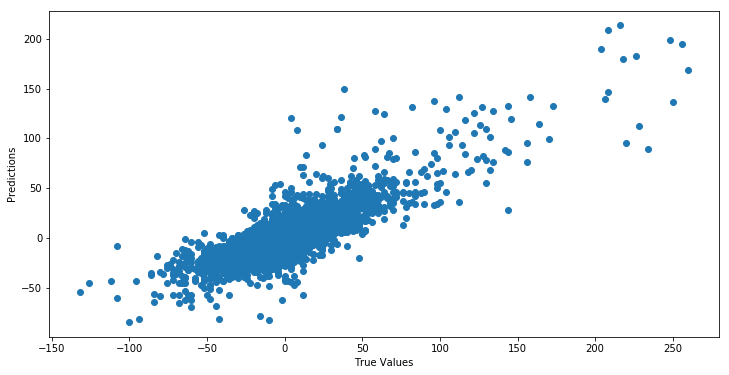

In [41]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score

# Create LR model and fit the training data
lr = LinearRegression()
lr.fit(X_train_norm, y_train)

# Make prediction
y_pred_lr = lr.predict(X_test_norm)

# Print model performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("RMSE: %f" % (rmse))
print('Train Score: ', lr.score(X_train_norm, y_train))
print('Test Score: ', lr.score(X_test_norm, y_test))

# print(lr.coef_)
# print(lr.intercept_)

# Plot prediction vs. actual
plt.rcParams['figure.figsize'] = (12, 6)
plt.scatter(y_test, y_pred_lr)
plt.xlabel('True Values')
plt.ylabel('Predictions')

RMSE: 9.968150
Train Score:  0.6431935016292878
Test Score:  0.6511035347288017


Text(0, 0.5, 'Predictions')

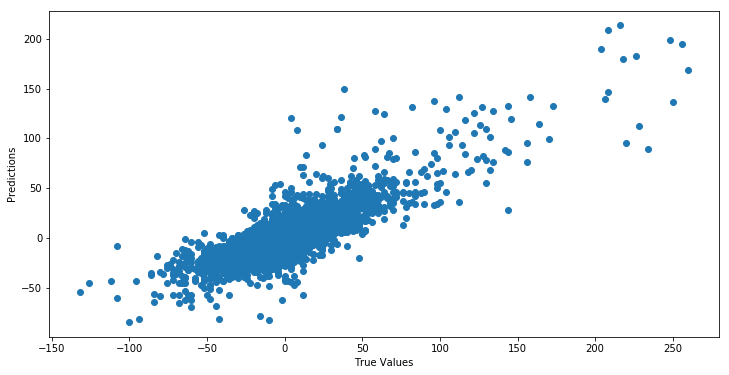

In [42]:
# Linear Regression with Regularization (Ridge)
from sklearn.linear_model import Ridge

# Create RR model and fit the training data
rr = Ridge(alpha=1.0)
rr.fit(X_train_norm, y_train)

# Make prediction
y_pred_rr = rr.predict(X_test_norm)

# Print model performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rr))
print("RMSE: %f" % (rmse))
print('Train Score: ', rr.score(X_train_norm, y_train))
print('Test Score: ', rr.score(X_test_norm, y_test))

# print(rr.coef_)
# print(rr.intercept_)

# Plot prediction vs. actual
plt.rcParams['figure.figsize'] = (12, 6)
plt.scatter(y_test, y_pred_rr)
plt.xlabel('True Values')
plt.ylabel('Predictions')

RMSE: 9.711590
Train Score:  0.6881842622337013
Test Score:  0.6688321591101427


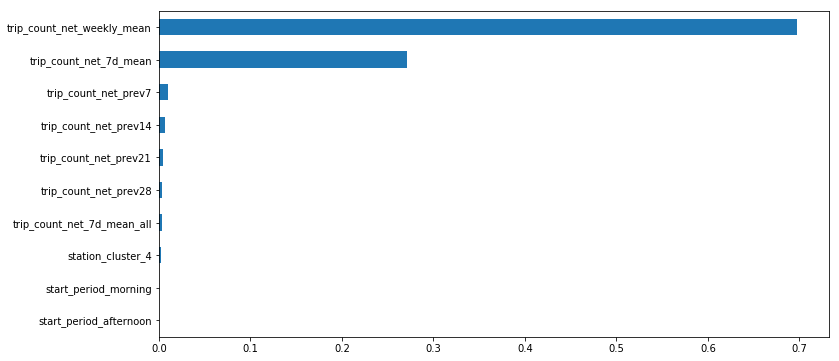

In [43]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Create RF regressor and fit the training data
rf = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=8)
rf.fit(X_train_norm, y_train)

# Make prediction
y_pred_rf = rf.predict(X_test_norm)

# Print model performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("RMSE: %f" % (rmse))
print('Train Score: ', rf.score(X_train_norm, y_train))
print('Test Score: ', rf.score(X_test_norm, y_test))

# Display feature importance
plt.rcParams['figure.figsize'] = (12, 6)
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances
feat_importances.nlargest(10).sort_values(axis=0, ascending=True).plot(kind='barh')

Text(0, 0.5, 'Predictions')

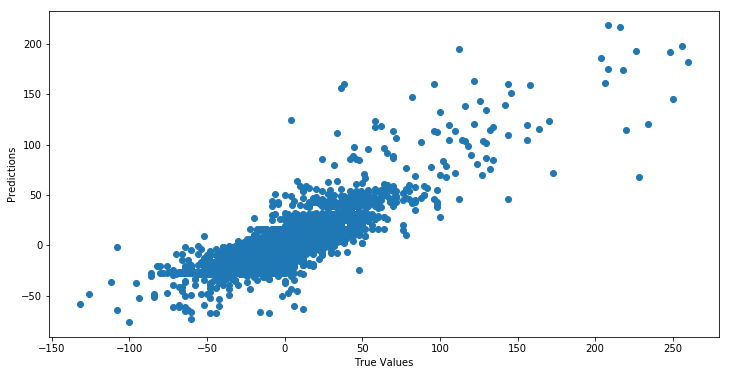

In [44]:
# Plot prediction vs. actual
plt.scatter(y_test, y_pred_rf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

RMSE: 9.634092
Train Score:  0.7357837198745449
Test Score:  0.6740965038008121


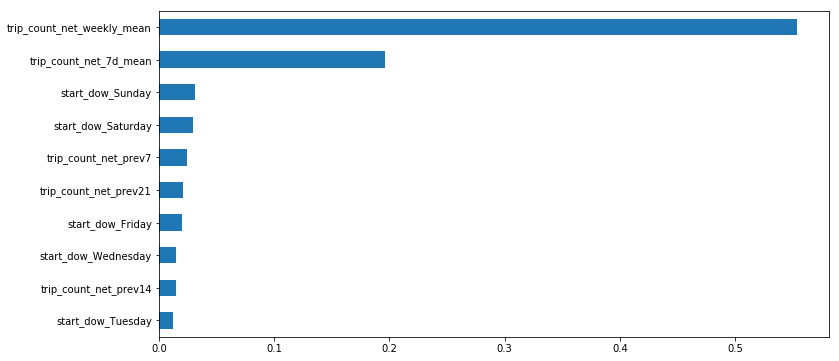

In [45]:
# XGBoost Regressor
import xgboost as xgb

# Create XGB regressor and fit the training data
xg = xgb.XGBRegressor(learning_rate=0.3, max_depth=3, n_estimators=100, early_stopping_rounds=10)
xg.fit(X_train_norm, y_train)

# Make prediction
y_pred_xg = xg.predict(X_test_norm)

# Print model performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xg))
print("RMSE: %f" % (rmse))
print('Train Score: ', xg.score(X_train_norm, y_train))
print('Test Score: ', xg.score(X_test_norm, y_test))

# Display feature importance
plt.rcParams['figure.figsize'] = (12, 6)
feat_importances = pd.Series(xg.feature_importances_, index=X_train.columns)
feat_importances
feat_importances.nlargest(10).sort_values(axis=0, ascending=True).plot(kind='barh')

# xgb.plot_importance(xg, max_num_features=10)

Text(0, 0.5, 'Predictions')

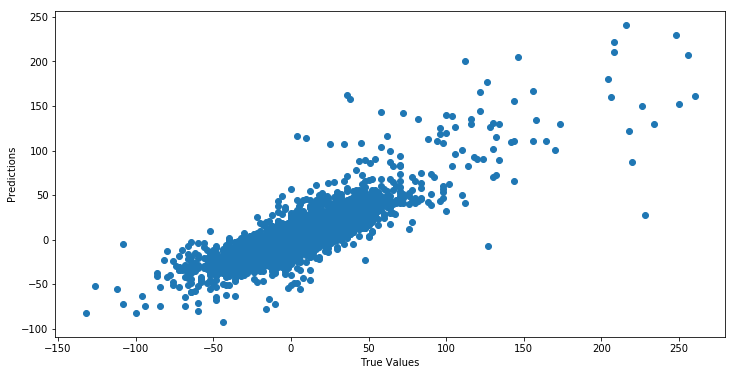

In [46]:
# Plot prediction vs. actual
plt.scatter(y_test, y_pred_xg)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [47]:
# K-fold cross-validation
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# Perform 5-fold cross validation
k = 5

scores = cross_val_score(xg, X_train, y_train, cv=k)
print('Cross-validated scores: ', scores)

Cross-validated scores:  [0.67635108 0.64648073 0.66418982 0.6821745  0.68346258]


In [346]:
# Make prediction on the last week of March 2019 using trips_feat

from sklearn.metrics import r2_score

trips_1w = trips_feat[trips_feat['start_date'] >= '2019-03-01']

onehot_cols = ['start_period', 'start_station_cluster', 'end_station_cluster', 'start_dow']
for k, v in enumerate(onehot_cols):
    one_hot = pd.get_dummies(trips_1w[v], prefix=v)
    trips_1w = trips_1w.drop(v, axis=1) # drop column as it is now encoded
    trips_1w = pd.concat([trips_1w, one_hot], axis=1) # join the encoded df

X_1w = trips_1w[trips_1w.columns.difference(['start_date', 'sum_duration_sec', 'sum_duration_min', 'datetime_hour', 'datetime_mod'
                                             , 'start_station_id', 'end_station_id', 'start_station_name', 'end_station_name'
                                             , 'trip_count', 'subscriber_trip_count', 'customer_trip_count'
                                             , 'start_station_has_kiosk', 'end_station_has_kiosk'
                                             , 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude'])]
y_1w = trips_1w['trip_count']

print(len(X_1w.columns))
print(X_1w.shape)
print(y_1w.shape)

# Normalize X_1d
# X_1w_norm = X_scaler.transform(X_1w)
X_1w_norm = X_1w.sort_index(axis=1)

# Make prediction using pre-trained model
y_pred_1w = xg.predict(X_1w_norm)

rmse = np.sqrt(mean_squared_error(y_1w, y_pred_1w))
print("RMSE: %f" % (rmse))
print('Prediction Score: ', xg.score(X_1w_norm, y_1w))
print('Prediction Score (Rounded): ', r2_score(y_1w, y_pred_1w.round()))
print(y_pred_1w)

trips_final = trips_1w
trips_final['trip_count_predicted'] = y_pred_1w.round()

# Output trips_final into .csv
trips_final.to_csv('../data/trips_final_20190301_20190331.csv')
trips_final[['trip_count', 'trip_count_predicted']]

40
(136471, 40)
(136471,)
RMSE: 0.802483
Prediction Score:  0.21682605733898094
Prediction Score (Rounded):  0.1586473289199175
[1.39314   1.2676853 1.1734054 ... 1.158771  1.2433732 1.158771 ]


,trip_count,trip_count_predicted
240,1,1.0
241,1,1.0
242,1,1.0
243,1,1.0
244,1,1.0
245,1,1.0
246,1,1.0
247,1,1.0
248,1,1.0
249,1,1.0


In [50]:
# Make prediction on the last week of March 2019 using trips_net_feat

from sklearn.metrics import r2_score

trips_1w = trips_net_feat[trips_net_feat['start_date'] >= '2019-03-01']

onehot_cols = ['start_period', 'station_cluster', 'start_dow']
for k, v in enumerate(onehot_cols):
    one_hot = pd.get_dummies(trips_1w[v], prefix=v)
    trips_1w = trips_1w.drop(v, axis=1) # drop column as it is now encoded
    trips_1w = pd.concat([trips_1w, one_hot], axis=1) # join the encoded df

X_1w = trips_1w[trips_1w.columns.difference(['start_date', 'station_id', 'trip_count_in', 'trip_count_out', 'trip_count_net'])]
y_1w = trips_1w['trip_count_net']

print(len(X_1w.columns))
print(X_1w.shape)
print(y_1w.shape)

# Normalize X_1d
# X_1w_norm = X_scaler.transform(X_1w)
X_1w_norm = X_1w.sort_index(axis=1)

# Make prediction using pre-trained model
y_pred_1w = xg.predict(X_1w_norm)

rmse = np.sqrt(mean_squared_error(y_1w, y_pred_1w))
print("RMSE: %f" % (rmse))
print('Prediction Score: ', xg.score(X_1w_norm, y_1w))
print('Prediction Score (Rounded): ', r2_score(y_1w, y_pred_1w.round()))
print(y_pred_1w)

trips_final = trips_1w
trips_final['trip_count_predicted'] = y_pred_1w.round()

# Output trips_final into .csv
trips_final.to_csv('../data/trips_final_20190301_20190331.csv')
trips_final[['trip_count_net', 'trip_count_predicted']]

29
(17194, 29)
(17194,)
RMSE: 5.537279
Prediction Score:  0.7313329254018555
Prediction Score (Rounded):  0.7306434335208387
[-3.7144923   4.4914336  10.22814    ... -0.05275947 -0.14270741
 -0.12999493]


,trip_count_net,trip_count_predicted
93988,-5.0,-4.0
93989,4.0,4.0
93990,3.0,10.0
93991,-11.0,-9.0
93992,-15.0,-13.0
93993,-16.0,-11.0
93994,6.0,-3.0
93995,-4.0,-6.0
93996,-13.0,-11.0
93997,-13.0,-14.0


Text(0, 0.5, 'Predictions')

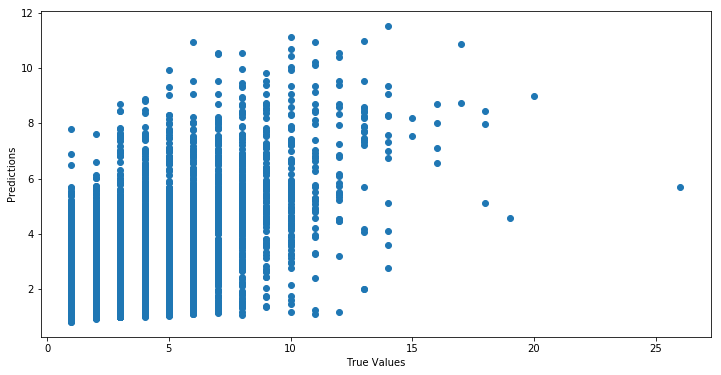

In [347]:
# Current status:
# R^2 is very low (~0.10) so need to make model much more complex to fight the high bias

plt.scatter(y_1w, y_pred_1w)
plt.xlabel('True Values')
plt.ylabel('Predictions')